## MICCAI SCM Baseline

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-02-03 18:04:37.802701: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-03 18:04:39.120584: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-03 18:04:41.097828: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from models import *
from data import * 
from env import *
from harmonize import *
from sim import *

In [4]:
# overall imports
import importlib
import data

from sim.sim import Simulation
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run, open_pickled_results

# data load
import data.data_utils
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_shared_matrices,
    process_cv_splits,  
    expanded_inner_folds_combined_plus_indices
)

import models
import models.metrics
from models.metrics import *

In [5]:
print_system_usage()
total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 36.1%
RAM Usage: 14.2%
Available RAM: 161.3G
Total RAM: 188.1G
52.4G


## Specify connectome and transcriptome

Full brain HCP Enigma

In [6]:
hemisphere = 'both'
PCA = True

HCP_enigma_structural_count, HCP_enigma_labels, HCP_enigma_lh_indices, HCP_enigma_rh_indices = load_connectome(measure='SC', omit_subcortical=False, include_labels=True, diag=0, hemisphere=hemisphere)
HCP_enigma_functional_conn = load_connectome(measure='FC', omit_subcortical=False, hemisphere=hemisphere)
HCP_coords = load_coords(parcellation='S100', omit_subcortical=False, hemisphere=hemisphere)
HCP_coords_left = load_coords(parcellation='S100', omit_subcortical=False, hemisphere='left')
HCP_coords_right = load_coords(parcellation='S100', omit_subcortical=False, hemisphere='right')
AHBAS100_transcriptome = load_transcriptome(parcellation='S100', omit_subcortical=False, hemisphere=hemisphere, run_PCA=PCA)

Number of components for 95% variance PCA: 34


Full brain HCP1200 and UKBB

In [7]:
hemisphere = 'left' # single hemisphere run is tractable within 2 minutes for closed form solution
PCA = True

HCP1200_structural_count, HCP1200_labels, HCP1200_lh_indices, HCP1200_rh_indices = load_connectome(measure='SC', parcellation='S400', omit_subcortical=False, include_labels=True)
HCP1200_functional_conn = load_connectome(measure='FC', parcellation='S400', omit_subcortical=False)
HCP1200_coords = load_coords(parcellation='S400', omit_subcortical=False)
AHBAS400_transcriptome = load_transcriptome(parcellation='S400', omit_subcortical=False, run_PCA=PCA)

# Find rows that are all NaN - there are 66 regions that are unsampled, and 9 cerebellar regions that are not assigned to hemispheres
nan_rows = np.isnan(AHBAS400_transcriptome).all(axis=1)
nan_row_indices = np.where(nan_rows)[0]
print(f"Original shape of AHBAS400_transcriptome: {AHBAS400_transcriptome.shape}")

# Get valid indices for left and right hemispheres by excluding NaN rows
valid_left_indices = [i for i in HCP1200_lh_indices if i not in nan_row_indices]
valid_right_indices = [i for i in HCP1200_rh_indices if i not in nan_row_indices]

if hemisphere == 'left':
    valid_indices = valid_left_indices
elif hemisphere == 'right':
    valid_indices = valid_right_indices
else: # Combine valid indices from both hemispheres
    valid_indices = valid_left_indices + valid_right_indices

# Subset transcriptome and connectomes to only include valid regions
AHBAS400_transcriptome = AHBAS400_transcriptome[valid_indices]
HCP1200_structural_count = HCP1200_structural_count[valid_indices][:, valid_indices]
HCP1200_functional_conn = HCP1200_functional_conn[valid_indices][:, valid_indices]
print(f"Shape of transcriptome after removing NaN regions: {AHBAS400_transcriptome.shape}")
print(f"Contains NaN values: {np.isnan(AHBAS400_transcriptome).any()}")
print("Shape of HCP1200_structural_count: ", HCP1200_structural_count.shape)
print("Shape of HCP1200_functional_conn: ", HCP1200_functional_conn.shape)

Number of components for 95% variance PCA: 105
Original shape of AHBAS400_transcriptome: (456, 105)
Shape of transcriptome after removing NaN regions: (214, 105)
Contains NaN values: False
Shape of HCP1200_structural_count:  (214, 214)
Shape of HCP1200_functional_conn:  (214, 214)


Assign features and targets

In [9]:
### S100 ###
X = AHBAS100_transcriptome
Y_sc = HCP_enigma_structural_count
Y_fc = HCP_enigma_functional_conn
Y = Y_sc
left_coords = HCP_coords_left
right_coords = HCP_coords_right

# ### S400 ###
# X = AHBAS400_transcriptome
# Y_sc = HCP1200_structural_count
# Y_fc = HCP1200_functional_conn
# Y = Y_sc
# left_coords = HCP1200_coords[valid_left_indices]
# right_coords = HCP1200_coords[valid_right_indices]

# Print shapes of feature and target matrices
print("Feature matrix X shape:", X.shape)
print("Structural connectivity Y_sc shape:", Y_sc.shape) 
print("Functional connectivity Y_fc shape:", Y_fc.shape)
print("Target matrix Y shape:", Y.shape)
print("Left coordinates shape:", left_coords.shape)
print("Right coordinates shape:", right_coords.shape)


Feature matrix X shape: (114, 34)
Structural connectivity Y_sc shape: (114, 114)
Functional connectivity Y_fc shape: (114, 114)
Target matrix Y shape: (114, 114)
Left coordinates shape: (57, 3)
Right coordinates shape: (57, 3)


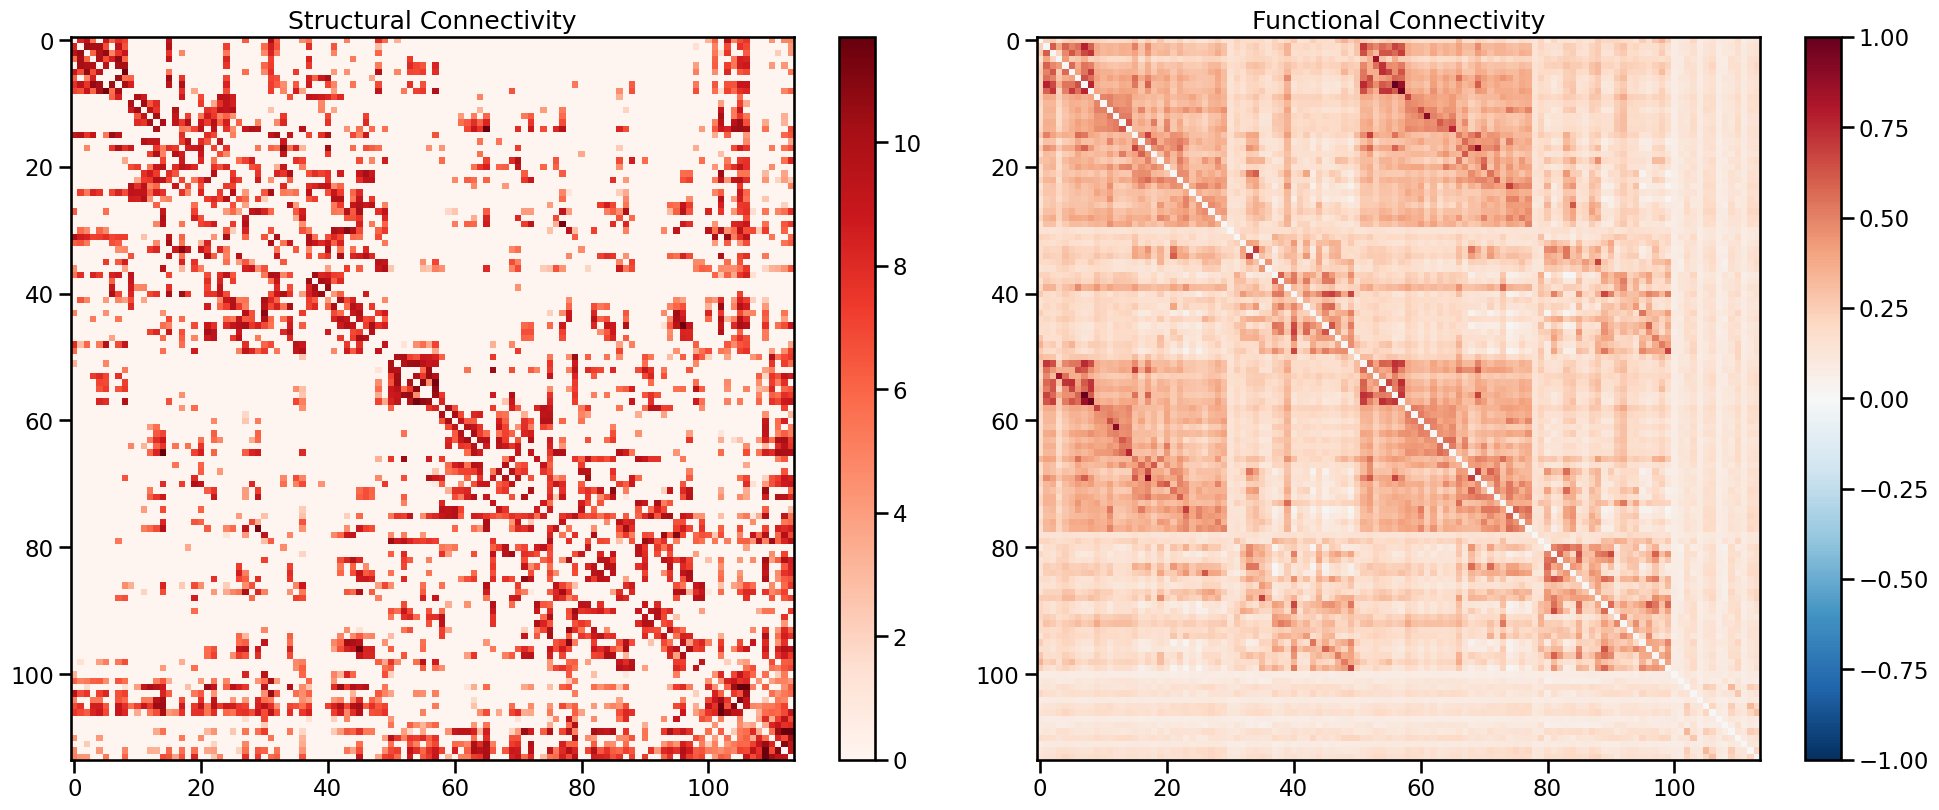

In [10]:
# Visualize structural and functional connectivity matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

im1 = ax1.imshow(Y_sc, cmap='Reds')
ax1.set_title('Structural Connectivity')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(Y_fc, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('Functional Connectivity') 
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()


## Fit SCM model

X shape: (114, 34)
K shape after Kronecker: (12996, 1156)
Y shape before flatten: (114, 114)
Y_flat shape: (12996,)
K_transpose_K shape: (1156, 1156)
K_reg shape: (1156, 1156)
K_pseudo_inv shape: (1156, 12996)
O_flat shape: (1156,)
Residuals shape: (12996,)
K_proj shape: (12996, 12996)
tau: 11840.0
objective: 0.0009260872407277864

SCM model metrics:
Pearson r: 0.574
R-squared: 0.01796
MSE: 9.98954


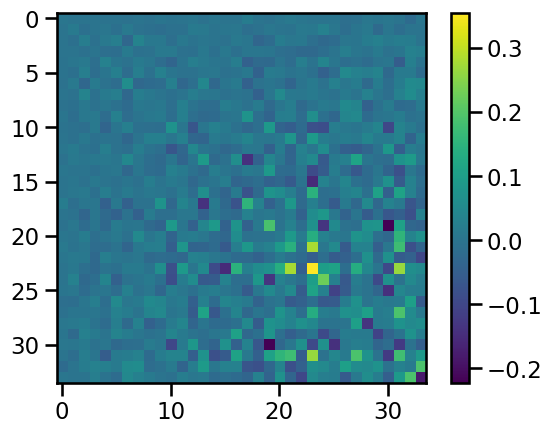

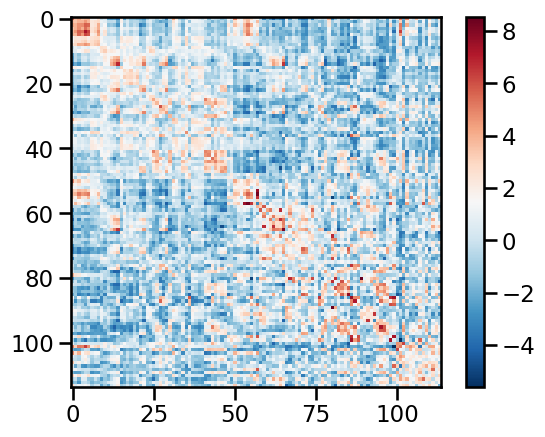

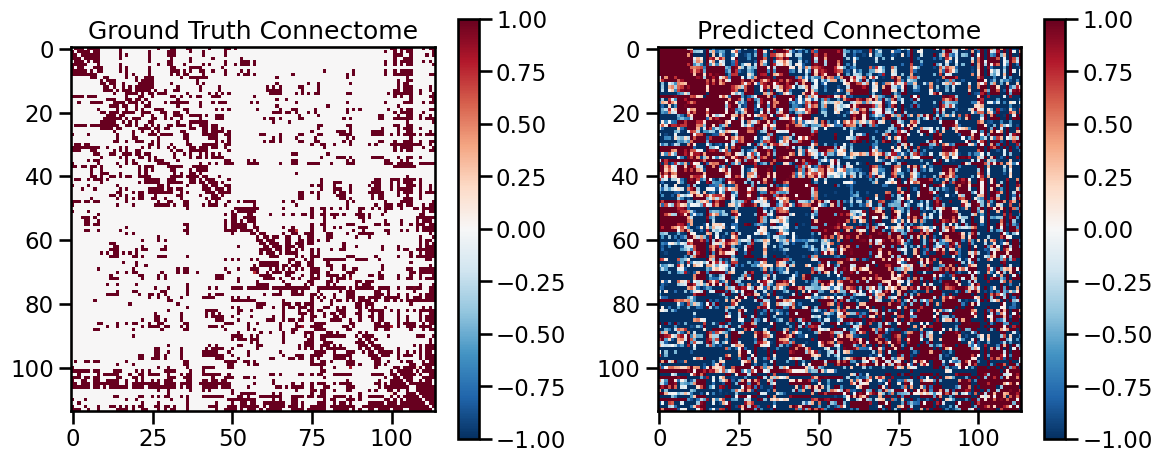

In [11]:
# Adapted from https://github.com/kpisti/SCM/tree/v1.0. Below implementation is aligned with Ridge Regression model from full paper.
def fit_scm(X, Y, alpha=0.0, verbose=True):
    """
    Fit Structural Covariance Model (SCM) to predict connectivity from gene expression.
    
    Args:
        X: Gene expression PCA matrix (regions x gene_PCA_dim)
        Y: Connectivity matrix (regions x regions) 
        alpha: Regularization parameter for ridge regression
        
    Returns:
        O: Estimated rule matrix (gene_PCA_dim x gene_PCA_dim)
        Y_pred: Predicted connectivity matrix (regions x regions)
        objective: Objective function value
    """
    # Compute Kronecker product of X with itself to obtain K matrix
    if verbose: print(f"X shape: {X.shape}")
    K = np.kron(X, X)  
    if verbose: print(f"K shape after Kronecker: {K.shape}")
    
    # Flatten connectivity matrix Y
    if verbose: print(f"Y shape before flatten: {Y.shape}")
    Y_flat = Y.flatten() 
    if verbose: print(f"Y_flat shape: {Y_flat.shape}")
    
    # Compute K transpose multiplied by K
    K_transpose_K = np.dot(K.T, K) 
    if verbose: print(f"K_transpose_K shape: {K_transpose_K.shape}")
    
    # Add regularization term
    # K_transpose_K /= np.linalg.norm(K_transpose_K)
    K_reg = K_transpose_K + alpha * np.identity(K_transpose_K.shape[0]) 
    if verbose: print(f"K_reg shape: {K_reg.shape}")

    # Compute the pseudo-inverse solution
    K_pseudo_inv = np.linalg.pinv(K_reg).dot(K.T)
    if verbose: print(f"K_pseudo_inv shape: {K_pseudo_inv.shape}")
    
    # Estimate the rule matrix in vectorized form
    O_flat = K_pseudo_inv.dot(Y_flat)
    if verbose: print(f"O_flat shape: {O_flat.shape}")
    
    # Compute residuals and objective
    residuals = Y_flat - np.dot(K, O_flat)
    if verbose: print(f"Residuals shape: {residuals.shape}")
    residual_norm = np.linalg.norm(residuals)

    K_proj = np.dot(K, K_pseudo_inv)
    if verbose: print(f"K_proj shape: {K_proj.shape}")
    
    tau = np.trace(np.identity(K_proj.shape[0]) - K_proj)
    if verbose: print(f"tau: {tau}")
    
    objective = residual_norm*residual_norm/tau/tau # ** 2)
    if verbose: print(f"objective: {objective}")
    
    # Reshape O to original dimensions
    O = O_flat.reshape(X.shape[1], X.shape[1])
    
    # Predict connectivity matrix
    Y_pred = np.dot(X, np.dot(O, X.T))
    
    # Min-max scale Y_pred to [-1,1] range
    return O, Y_pred, objective

# Fit the default unregularized model
O, Y_pred, objective = fit_scm(X, Y)

# Flatten matrices for calculations
y_true = Y.flatten()
y_pred = Y_pred.flatten()

# Metrics
pearson_r, _ = stats.pearsonr(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print("\nSCM model metrics:")
print(f"Pearson r: {pearson_r:.3f}")
print(f"R-squared: {r2:.5f}") 
print(f"MSE: {mse:.5f}")

plt.imshow(O)
plt.colorbar()
plt.show()

im = plt.imshow(Y_pred, cmap='RdBu_r')
plt.colorbar(im)
plt.show()

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ground truth connectome
im1 = ax1.imshow(Y, cmap='RdBu_r', vmin=-1, vmax=1)
ax1.set_title('Ground Truth Connectome')
plt.colorbar(im1, ax=ax1)

# Plot predicted connectome  
im2 = ax2.imshow(Y_pred, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('Predicted Connectome')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()



0 - 0.0009260872407277864
0.001 - 0.0009260872230263732
0.01 - 0.0009260870637144676
0.1 - 0.0009260854706759406
1 - 0.0009260695483394719
10 - 0.000925911125664771
100 - 0.0009244030038395036
1000 - 0.0009143790550218045


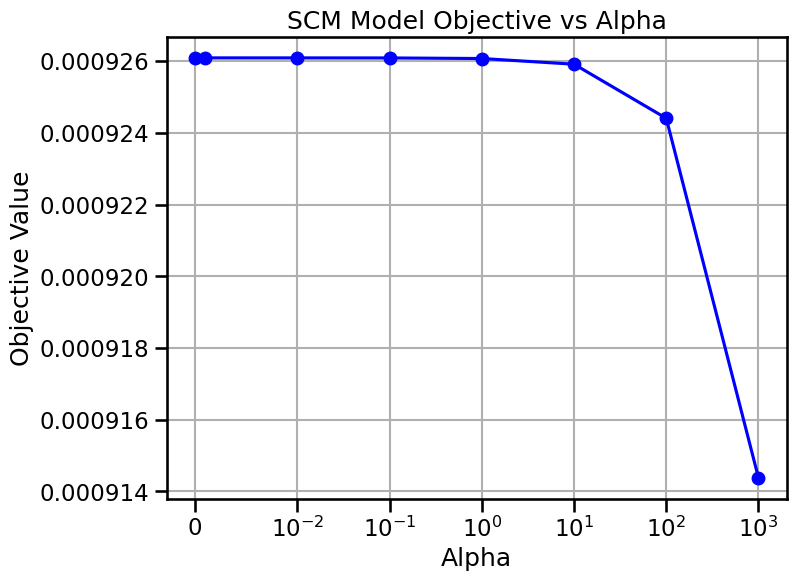

In [12]:
def grid_search_alpha(X, Y, alpha_values):
    objectives = []
    for alpha in alpha_values:
        _, _, obj = fit_scm(X, Y, alpha=alpha, verbose=False)
        print(alpha, '-',  obj)
        objectives.append(obj)
    
    # Plot alpha vs objective
    plt.figure(figsize=(8, 6))
    plt.plot(alpha_values, objectives, 'bo-')
    plt.xscale('symlog', linthresh=0.01)  # Log scale that handles 0
    plt.xlabel('Alpha')
    plt.ylabel('Objective Value') 
    plt.title('SCM Model Objective vs Alpha')
    plt.grid(True)
    plt.show()
    
    return alpha_values, objectives

# Run grid search
#alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
alphas = [0, 0.001, 0.01, 0.1, 1, 10, 10**2, 10**3]
alpha_values, objectives = grid_search_alpha(X, Y, alphas)


permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
hemisphere:  both
rotated_ids shape: (114, 1000)
permutation: 0
permutation: 50
permutation: 100
permutation: 150
permutation: 200
permutation: 250
permutation: 300
permutation: 350
permutation: 400
permutation: 450
permutation: 500
permutation: 550
permutation: 600
permutation: 650
permutation: 700
permutation: 750
permutation: 800
permutation: 850
permutation: 900
permutation: 950


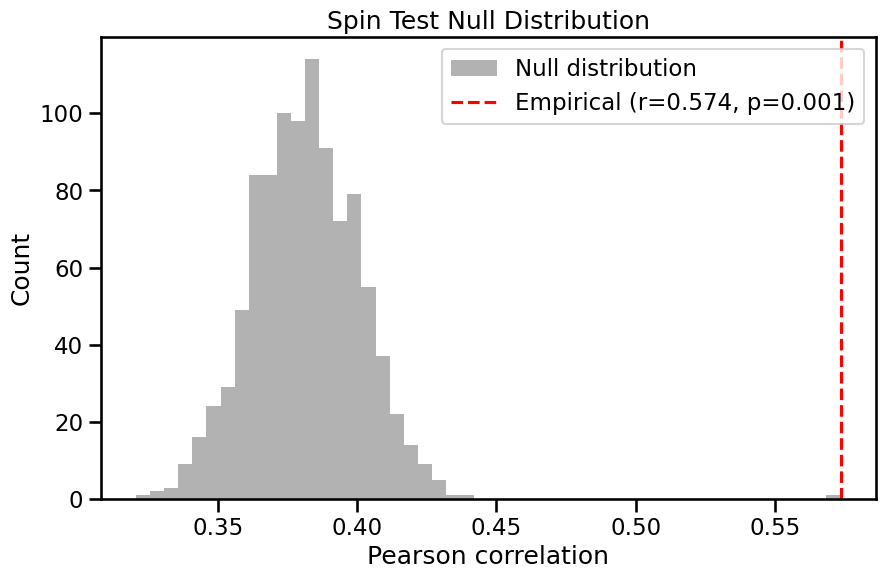

In [13]:
def run_spin_test(X, Y_true, left_coords, right_coords, hemisphere, n_perms=100, shuffle_target=True):
    """
    Run spin test permutation analysis for SCM model
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Input transcriptome data
    Y_true : array-like of shape (n_samples, n_samples) 
        Input connectome data
    left_coords : array-like
        Left hemisphere coordinates
    right_coords : array-like  
        Right hemisphere coordinates
    n_perms : int, default=100
        Number of permutations for null distribution
    shuffle_target : bool, default=True
        If True, shuffle connectome (Y). If False, shuffle transcriptome (X)
        
    Returns:
    --------
    empirical_corr : float
        Empirical correlation
    p_value : float
        P-value from permutation test
    null_corrs : array
        Null distribution correlations
    """
    # Calculate empirical correlation
    O, Y_pred, _ = fit_scm(X, Y_true, verbose=False)
    empirical_corr = stats.pearsonr(Y_true.flatten(), Y_pred.flatten())[0]

    # Generate all rotations beforehand
    rotated_ids = rotate_parcellation(left_coords, right_coords, nrot=n_perms)
    rotated_ids = rotated_ids.astype(int)
    
    print('hemisphere: ', hemisphere)
    if hemisphere == 'left':
        rotated_ids = rotated_ids[:len(left_coords)]
    elif hemisphere == 'right':
        rotated_ids = rotated_ids[len(left_coords):]

    print(f"rotated_ids shape: {rotated_ids.shape}")
    # Initialize array to store null correlations
    null_corrs = np.zeros(n_perms)

    # Generate null distribution
    for i in range(n_perms):
        if i % 50 == 0:
            print(f"permutation: {i}")
        perm_ids = rotated_ids[:, i]
        
        if shuffle_target: # Shuffle connectome
            Y_rotated = Y_true[perm_ids][:, perm_ids]
            X_rotated = X
        else: # Shuffle transcriptome   
            Y_rotated = Y_true
            X_rotated = X[perm_ids]
        
        # Fit SCM on rotated data
        O_null, Y_pred_null, _ = fit_scm(X_rotated, Y_rotated, verbose=False)
        
        # Calculate correlation
        null_corrs[i] = stats.pearsonr(Y_rotated.flatten(), Y_pred_null.flatten())[0]

    # Calculate p-value
    p_value = np.mean(null_corrs >= empirical_corr)

    # Plot null distribution
    plt.figure(figsize=(10, 6))
    plt.hist(null_corrs, bins=50, alpha=0.6, color='gray', label='Null distribution')
    plt.axvline(empirical_corr, color='red', linestyle='--', 
                label=f'Empirical (r={empirical_corr:.3f}, p={p_value:.3f})')
    plt.xlabel('Pearson correlation')
    plt.ylabel('Count')
    plt.title('Spin Test Null Distribution')
    plt.legend()
    plt.show()
    
    return empirical_corr, p_value, null_corrs

# Run the spin test
empirical_corr, p_value, null_distribution = run_spin_test(
    X=X,
    Y_true=Y,
    left_coords=left_coords,
    right_coords=right_coords,
    hemisphere='both',
    n_perms=1000,
    shuffle_target=False
)


### Pytorch SCM model

In [19]:
from models.bilinear import BilinearSCM  # using gradient based optimization

X_expanded = expand_X_symmetric(X) # PCA version
Y_expanded = expand_Y_symmetric(Y)
print('X_expanded.shape: ', X_expanded.shape)
print('Y_expanded.shape: ', Y_expanded.shape)

scm_torch_model = BilinearSCM(input_dim=X_expanded.shape[1], learning_rate=0.0003, epochs=200, 
                 batch_size=400, regularization='l2', lambda_reg=0.0, bias=True)

scm_torch_model.fit(X_expanded, Y_expanded)
Y_pred = scm_torch_model.predict(X_expanded)


X_expanded.shape:  (12882, 68)
Y_expanded.shape:  (12882,)
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 5/200, Train Loss: 107.6272
Epoch 10/200, Train Loss: 62.2364
Epoch 15/200, Train Loss: 39.7890
Epoch 20/200, Train Loss: 27.2709
Epoch 25/200, Train Loss: 20.3881
Epoch 30/200, Train Loss: 16.1630
Epoch 35/200, Train Loss: 13.5166
Epoch 40/200, Train Loss: 11.8538
Epoch 45/200, Train Loss: 10.7820
Epoch 50/200, Train Loss: 9.9364
Epoch 55/200, Train Loss: 9.2813
Epoch 60/200, Train Loss: 8.8415
Epoch 65/200, Train Loss: 8.4509
Epoch 70/200, Train Loss: 8.2990
Epoch 75/200, Train Loss: 8.0477
Epoch 80/200, Train Loss: 7.8011
Epoch 85/200, Train Loss: 7.6929
Epoch 90/200, Train Loss: 7.5595
Epoch 95/200, Train Loss: 7.4583
Epoch 100/200, Train Loss: 7.3974
Epoch 105/200, Train Loss: 7.2161
Epoch 110/200, Train Loss: 7.2312
Epoch 115/200, Train Loss: 7.2496
Epoch 120/200, Train Loss: 7.0770
Epoch 125/200, Train Loss: 7.0842
Epoch 130/200, Train Loss: 7.0453
Epoch 13

Bilinear layer weights shape: (1, 34, 34)

Bilinear weights:
[[[ 4.6254909e-03 -3.5630865e-04 -7.0966926e-04 ... -2.1748901e-03
   -1.9465933e-02  3.4615730e-03]
  [-6.9274654e-04  1.6279908e-02 -9.9681094e-03 ... -1.4320017e-02
    7.8800746e-04  3.0810665e-04]
  [-7.6028064e-04 -9.4686104e-03  2.7489541e-02 ...  1.9454772e-02
    2.1888716e-02  2.4657308e-03]
  ...
  [-1.6743488e-03 -1.3967328e-02  2.1367749e-02 ...  3.0748835e-01
    2.1735435e-02  9.6900150e-02]
  [-2.0099418e-02 -2.0843637e-03  2.0886136e-02 ...  2.5552979e-02
    1.6676401e-01  2.0265254e-01]
  [ 3.3015923e-03 -1.9835014e-04  1.2463762e-03 ...  9.9002711e-02
    1.9803949e-01  6.4244713e-03]]]

Bilinear bias:
[1.6415795]


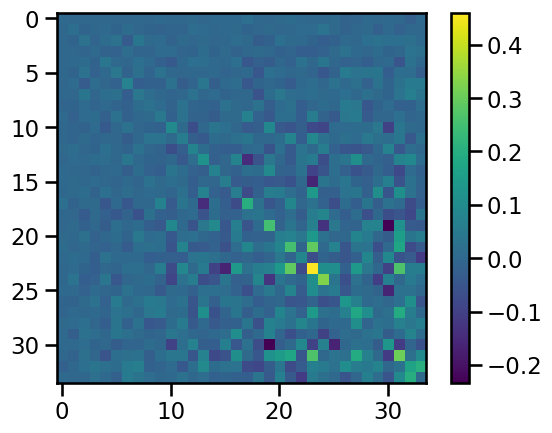

In [20]:
# Get bilinear layer weights
bilinear_weights = scm_torch_model.bilinear.weight.detach().cpu().numpy()
bilinear_bias = scm_torch_model.bilinear.bias.detach().cpu().numpy()

print("Bilinear layer weights shape:", bilinear_weights.shape)
print("\nBilinear weights:")
print(bilinear_weights)
print("\nBilinear bias:")
print(bilinear_bias)

plt.imshow(bilinear_weights.reshape(bilinear_weights.shape[-2], bilinear_weights.shape[-1]))
plt.colorbar()
plt.show()


In [21]:
# Calculate metrics
pearson = stats.pearsonr(Y_expanded, Y_pred)[0]
mse = np.mean((Y_expanded - Y_pred)**2)
r2 = r2_score(Y_expanded, Y_pred)
print(f"Pearson correlation: {pearson:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R2 score: {r2:.3f}")

Y_pred = reconstruct_connectome(Y_pred)

Pearson correlation: 0.599
MSE: 6.603
R2 score: 0.355


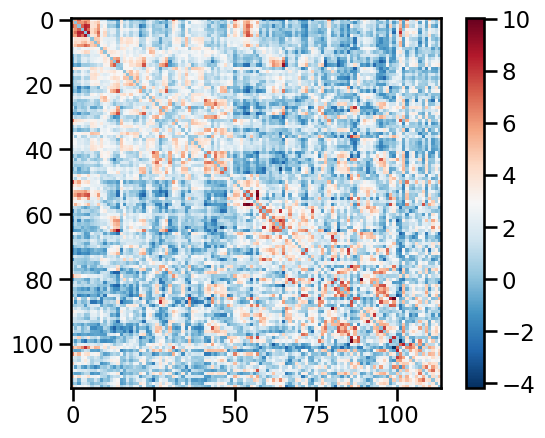

In [25]:
im = plt.imshow(Y_pred, cmap='RdBu_r')
plt.colorbar(im)
plt.show()

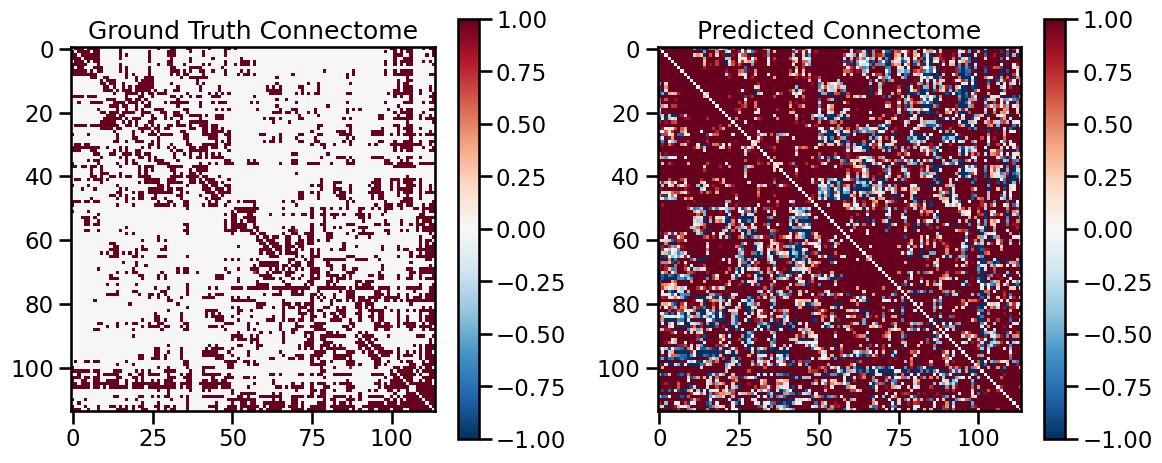

In [23]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ground truth connectome
im1 = ax1.imshow(Y, cmap='RdBu_r', vmin=-1, vmax=1)
ax1.set_title('Ground Truth Connectome')
plt.colorbar(im1, ax=ax1)

# Plot predicted connectome  
im2 = ax2.imshow(Y_pred, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('Predicted Connectome')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

### Run a train test split for the SCM model

In [9]:
# Run simulation
single_sim_run(
              cv_type='random',
              random_seed=42,
              model_type='bilinear_SCM',
              feature_type=[{'transcriptome': 'PCA'}],
              connectome_target='FC',
              use_gpu=True,
              use_shared_regions=False,
              test_shared_regions=False,
              omit_subcortical=False,
              parcellation='S100',
              gene_list='0.2',
              hemisphere='both',
              search_method=('wandb', 'mse', 20),
              save_sim=False,
              track_wandb=True,
              skip_cv=False
              )

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
# Clear CPU memory
gc.collect()

Number of components for 95% variance PCA: 34
X shape: (114, 10760)
X_pca shape: (114, 34)
Y_sc shape: (114, 114)
Y_sc_spectralL shape: (114, 113)
Y_sc_spectralA shape: (114, 114)
Y_fc shape: (114, 114)
Coordinates shape: (114, 3)
Y shape (114, 114)
feature_name:  transcriptome
processing_type:  PCA
X shape (114, 34)

 Test fold num: 1 X_train shape: (7140, 68) Y_train shape: (7140,) X_test shape: (812, 68) Y_test shape: (812,)


  return LooseVersion(v) >= LooseVersion(check)

ERROR: Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: asratzan (alexander-ratzan-new-york-university). Use `wandb login --relogin` to force relogin


2
3
4


wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. Additional properties are not allowed ('best_parameters' was unexpected)


Create sweep with ID: 1aecuasa
Sweep URL: https://wandb.ai/alexander-ratzan-new-york-university/gx2conn/sweeps/1aecuasa


wandb: Agent Starting Run: i2e5rni5 with config:
wandb: 	batch_size: 260
wandb: 	epochs: 230
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.14210742936609308
wandb: 	learning_rate: 0.0005503513690428881
wandb: 	regularization: l2
ERROR: Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157


  warnings.warn(



Epoch 10/230, Train Loss: 100.7545, Val Loss: 126.9378
Epoch 20/230, Train Loss: 41.0513, Val Loss: 77.1756
Epoch 30/230, Train Loss: 20.1693, Val Loss: 58.7604
Epoch 40/230, Train Loss: 11.8715, Val Loss: 43.0349


  return tuple(tensor[index] for tensor in self.tensors)



Epoch 50/230, Train Loss: 7.8506, Val Loss: 37.9131
Epoch 60/230, Train Loss: 5.5314, Val Loss: 31.8340
Epoch 70/230, Train Loss: 4.0943, Val Loss: 25.1187
Epoch 80/230, Train Loss: 3.1478, Val Loss: 25.9241
Epoch 90/230, Train Loss: 2.4999, Val Loss: 23.5211
Epoch 100/230, Train Loss: 2.0301, Val Loss: 16.3040
Epoch 110/230, Train Loss: 1.6812, Val Loss: 15.1546
Epoch 120/230, Train Loss: 1.4172, Val Loss: 14.0076
Epoch 130/230, Train Loss: 1.2005, Val Loss: 12.6324
Epoch 140/230, Train Loss: 1.0304, Val Loss: 10.1506
Epoch 150/230, Train Loss: 0.8913, Val Loss: 10.1014
Epoch 160/230, Train Loss: 0.7748, Val Loss: 8.3792
Epoch 170/230, Train Loss: 0.6768, Val Loss: 7.4583
Epoch 180/230, Train Loss: 0.5928, Val Loss: 5.9997
Epoch 190/230, Train Loss: 0.5233, Val Loss: 6.2698
Epoch 200/230, Train Loss: 0.4621, Val Loss: 5.2997
Epoch 210/230, Train Loss: 0.4092, Val Loss: 4.3301
Epoch 220/230, Train Loss: 0.3635, Val Loss: 4.0163
Epoch 230/230, Train Loss: 0.3235, Val Loss: 3.5483
Proces

  from IPython.core.display import HTML, display  # type: ignore



fold0_epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▆▆▆▆▆▆▆▇▇▇▇▇███
fold0_train_loss,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▂▃▃▃▃▃▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▆▅▆▆▇▇▇▇▇█
fold0_val_loss,█▆▄▄▅▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▂▅▁▄▄▁▃▅▁▂▃▂█▂▃▇▂▁▆▃▆▄▃▄▃▅▄▇▂▅▅▆▄█▅▃▆▃▅▅
fold1_epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█████
fold1_train_loss,█▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▂▃▂▂▂▂▂▂▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▆▅▅▆▇▇████
fold1_val_loss,█▇▆▆▆▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
fold1_val_pearson,▁▂▂▂▃▃▃▄▃▃▄▃▃▅▄▄▃▅▅▆▆█▄▆▇█▆▇▇▅▆▇███▇██▇▆
fold2_epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jyudasf4 with config:
wandb: 	batch_size: 372
wandb: 	epochs: 215
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.003870786985288156
wandb: 	learning_rate: 0.001013210808359246
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/215, Train Loss: 47.4314, Val Loss: 49.2639
Epoch 20/215, Train Loss: 14.7240, Val Loss: 40.9613
Epoch 30/215, Train Loss: 6.5488, Val Loss: 20.0967
Epoch 40/215, Train Loss: 3.6741, Val Loss: 19.6003
Epoch 50/215, Train Loss: 2.4157, Val Loss: 15.1565
Epoch 60/215, Train Loss: 1.6958, Val Loss: 10.1454


  return tuple(tensor[index] for tensor in self.tensors)



Epoch 70/215, Train Loss: 1.2442, Val Loss: 10.6048
Epoch 80/215, Train Loss: 0.9320, Val Loss: 8.7574
Epoch 90/215, Train Loss: 0.7190, Val Loss: 6.9964
Epoch 100/215, Train Loss: 0.5699, Val Loss: 6.2835
Epoch 110/215, Train Loss: 0.4581, Val Loss: 5.6956
Epoch 120/215, Train Loss: 0.3763, Val Loss: 5.3559
Epoch 130/215, Train Loss: 0.3019, Val Loss: 4.9948
Epoch 140/215, Train Loss: 0.2588, Val Loss: 4.7617
Epoch 150/215, Train Loss: 0.2111, Val Loss: 4.0341
Epoch 160/215, Train Loss: 0.1792, Val Loss: 3.0943
Epoch 170/215, Train Loss: 0.1519, Val Loss: 3.9212
Epoch 180/215, Train Loss: 0.1297, Val Loss: 2.9608
Epoch 190/215, Train Loss: 0.1112, Val Loss: 3.2036
Epoch 200/215, Train Loss: 0.0969, Val Loss: 2.3192
Epoch 210/215, Train Loss: 0.0843, Val Loss: 2.6458
Processing inner fold 1
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/215, Train Loss: 86.8148, Val Loss: 86.0775
Epoch 20/215, Train Loss: 24.4242, Val Loss: 102.5193
Epoch 30/215, Train Loss: 10.723

fold0_epoch,▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
fold0_train_loss,█▆▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▃▃▂▃▃▃▃▂▂▁▁▁▂▁▂▂▃▃▃▃▃▃▃▃▄▃▄▄▄▄▅▄▅▆▇▇▇▇▇█
fold0_val_loss,█▇▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▃▆▅▅▆▄▄▇▅▇▇▃▆▆▆▆▆▅▂▂▅▂▄▂▃▄▃█▄▁▆▄▁▄▄▆▃▄▆▅
fold1_epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
fold1_train_loss,█▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▁▂▂▂▂▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▇▇▇▇▇██████
fold1_val_loss,█▅█▄▆▆▄▃▄▃▂▃▂▂▄▂▂▂▃▂▂▂▂▂▁▃▁▂▃▂▂▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▄▅▂▃▇▇▂▆▃▁█▆█▅▄▅▅▄█▇▅▃▃▄███▇▄▂▅▃▃▇▃▃▇▆▆▆
fold2_epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇███


wandb: Agent Starting Run: 6qze4rjn with config:
wandb: 	batch_size: 475
wandb: 	epochs: 167
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.0017420186203956805
wandb: 	learning_rate: 0.0012302882301645707
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/167, Train Loss: 68.7106, Val Loss: 87.4633
Epoch 20/167, Train Loss: 20.1146, Val Loss: 47.2174
Epoch 30/167, Train Loss: 8.4932, Val Loss: 32.0709
Epoch 40/167, Train Loss: 4.7570, Val Loss: 22.9009


  return tuple(tensor[index] for tensor in self.tensors)



Epoch 50/167, Train Loss: 3.0629, Val Loss: 16.9607
Epoch 60/167, Train Loss: 2.1297, Val Loss: 14.6868
Epoch 70/167, Train Loss: 1.5275, Val Loss: 11.4103
Epoch 80/167, Train Loss: 1.1448, Val Loss: 9.7376
Epoch 90/167, Train Loss: 0.8754, Val Loss: 7.9721
Epoch 100/167, Train Loss: 0.6892, Val Loss: 6.8358
Epoch 110/167, Train Loss: 0.5505, Val Loss: 5.9742
Epoch 120/167, Train Loss: 0.4414, Val Loss: 5.2129
Epoch 130/167, Train Loss: 0.3549, Val Loss: 4.6111
Epoch 140/167, Train Loss: 0.2883, Val Loss: 4.0817
Epoch 150/167, Train Loss: 0.2474, Val Loss: 3.5710
Epoch 160/167, Train Loss: 0.2050, Val Loss: 3.2931
Processing inner fold 1
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/167, Train Loss: 27.5127, Val Loss: 85.4248
Epoch 20/167, Train Loss: 8.6964, Val Loss: 64.9256
Epoch 30/167, Train Loss: 4.2902, Val Loss: 52.2474
Epoch 40/167, Train Loss: 2.6469, Val Loss: 46.6584
Epoch 50/167, Train Loss: 1.8084, Val Loss: 40.7509
Epoch 60/167, Train Loss: 1.3201, 

fold0_epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇██
fold0_train_loss,█▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▇▇▅▅▃▁▂▁▂▁▁▂▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▆▅▆▆▆▇▇▇██
fold0_val_loss,█▇▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,█▇▅▂▂▁▂▂▄▃▃▅▂▄▃▂▃▃▃▃▃▃▄▄▃▄▄▄▄▃▄▃▃▄▄▄▄▄▃▄
fold1_epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
fold1_train_loss,█▇▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇██
fold1_val_loss,██▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▂▁▁▂▂▃▃▅▄▃▄▄▄▄▅▄▄▅▅▄▄▅▆▅▇▅▅▄▆▇▆▆▆▇▆▇▇▇█▇
fold2_epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h072y2nx with config:
wandb: 	batch_size: 512
wandb: 	epochs: 181
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.1084839452860318
wandb: 	learning_rate: 0.0005747923681180226
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/181, Train Loss: 141.0612, Val Loss: 180.0222
Epoch 20/181, Train Loss: 107.5574, Val Loss: 149.8588
Epoch 30/181, Train Loss: 54.6470, Val Loss: 116.7555
Epoch 40/181, Train Loss: 43.0189, Val Loss: 102.9765


  transposed = list(zip(*batch))  # It may be accessed twice, so we use a list.



Epoch 50/181, Train Loss: 26.9459, Val Loss: 89.0706
Epoch 60/181, Train Loss: 20.5168, Val Loss: 75.5063
Epoch 70/181, Train Loss: 21.2460, Val Loss: 74.4239
Epoch 80/181, Train Loss: 13.7870, Val Loss: 62.6009
Epoch 90/181, Train Loss: 11.4781, Val Loss: 57.8863
Epoch 100/181, Train Loss: 10.5060, Val Loss: 51.8603
Epoch 110/181, Train Loss: 8.0371, Val Loss: 50.0436
Epoch 120/181, Train Loss: 8.0866, Val Loss: 43.6431
Epoch 130/181, Train Loss: 6.1442, Val Loss: 40.3354
Epoch 140/181, Train Loss: 5.8597, Val Loss: 39.9398
Epoch 150/181, Train Loss: 5.3821, Val Loss: 33.8746
Epoch 160/181, Train Loss: 4.4463, Val Loss: 29.6802
Epoch 170/181, Train Loss: 4.1028, Val Loss: 32.2413
Epoch 180/181, Train Loss: 3.3348, Val Loss: 26.2263
Processing inner fold 1
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/181, Train Loss: 158.5006, Val Loss: 110.2544
Epoch 20/181, Train Loss: 72.3778, Val Loss: 99.8842
Epoch 30/181, Train Loss: 40.1012, Val Loss: 78.5688
Epoch 40/181,

fold0_epoch,▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
fold0_train_loss,█▇▆▆▆▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▄▇█▁▇█▆▇▇▃▂▅▄▆▃▄▆▄▄▂▁▃▃▄▂▃▂▄▅▂▃▅▄▂▃▄▃▅▅▇
fold0_val_loss,██▇▇▇▆▅▅▅▅▅▅▄▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,█▇█▇▅▃▃▂▂▃▂▄▃▂▂▂▄▃▁▂▂▂▃▃▁▂▄▂▂▂▂▂▂▃▂▃▂▁▂▃
fold1_epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇███
fold1_train_loss,██▆▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▂▁▂▂▃▄▄▃▄▄▆▅▆▅▇▆▇▇▇█▇█▇█▇▇▇▇▇▇▇▇▇▇▇▇▆▇▆▇
fold1_val_loss,██▆▇▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▄▃▂▃▃▂▃▂▁▄▄▃▃▂▅▄▅▂▂▃▁▃▅▆▅▃▄▅▄▆▆▄▆██▇█▆▇█
fold2_epoch,▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█


wandb: Agent Starting Run: v68udofu with config:
wandb: 	batch_size: 311
wandb: 	epochs: 198
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.43459747107425095
wandb: 	learning_rate: 0.0028402108634334104
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/198, Train Loss: 10.7677, Val Loss: 54.2864
Epoch 20/198, Train Loss: 3.3058, Val Loss: 25.2524
Epoch 30/198, Train Loss: 1.6996, Val Loss: 17.7148
Epoch 40/198, Train Loss: 1.0188, Val Loss: 8.4234
Epoch 50/198, Train Loss: 0.6377, Val Loss: 5.7604
Epoch 60/198, Train Loss: 0.3987, Val Loss: 3.0099
Epoch 70/198, Train Loss: 0.2416, Val Loss: 1.2201
Epoch 80/198, Train Loss: 0.1417, Val Loss: 0.4860
Epoch 90/198, Train Loss: 0.0889, Val Loss: 0.1932
Epoch 100/198, Train Loss: 0.0703, Val Loss: 0.0897
Epoch 110/198, Train Loss: 0.0670, Val Loss: 0.0755
Epoch 120/198, Train Loss: 0.0668, Val Loss: 0.0734
Epoch 130/198, Train Loss: 0.0668, Val Loss: 0.0734
Epoch 140/198, Train Loss: 0.0671, Val Loss: 0.0749
Epoch 150/198, Train Loss: 0.0648, Val Loss: 0.0747
Epoch 160/198, Train Loss: 0.0649, Val Loss: 0.0736


  return tuple(tensor[index] for tensor in self.tensors)



Epoch 170/198, Train Loss: 0.0649, Val Loss: 0.0737
Epoch 180/198, Train Loss: 0.0647, Val Loss: 0.0753
Epoch 190/198, Train Loss: 0.0646, Val Loss: 0.0745
Processing inner fold 1
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/198, Train Loss: 9.1685, Val Loss: 83.3390
Epoch 20/198, Train Loss: 3.2508, Val Loss: 64.4229
Epoch 30/198, Train Loss: 1.9993, Val Loss: 52.3858
Epoch 40/198, Train Loss: 1.3978, Val Loss: 40.1630
Epoch 50/198, Train Loss: 0.9563, Val Loss: 35.9236
Epoch 60/198, Train Loss: 0.6578, Val Loss: 24.2546
Epoch 70/198, Train Loss: 0.4530, Val Loss: 15.5325
Epoch 80/198, Train Loss: 0.3071, Val Loss: 10.1549
Epoch 90/198, Train Loss: 0.1974, Val Loss: 5.1474
Epoch 100/198, Train Loss: 0.1285, Val Loss: 2.1036
Epoch 110/198, Train Loss: 0.0872, Val Loss: 0.6754
Epoch 120/198, Train Loss: 0.0705, Val Loss: 0.1999
Epoch 130/198, Train Loss: 0.0651, Val Loss: 0.1036
Epoch 140/198, Train Loss: 0.0646, Val Loss: 0.0901
Epoch 150/198, Train Loss: 0.0649,

fold0_epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
fold0_train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▄▅▅▆▇▇▇▇▇▇█▇███████████
fold0_val_loss,█▆▆▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▁▂▂▂▁▂▂▁▂▃▂▃▃▃▄▄▅▅▆▆█▇▇█▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇
fold1_epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
fold1_train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▆▇▇▇▇▇▇████████
fold1_val_loss,█▇▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▄▄▄▃▃▄▄▃▃▃▃▃▃▄▃▃▃▂▂▂▁▁▁▁▁▃▆▆▇▇▇█▇█▇▇██▇▇
fold2_epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: f1zdtxk5 with config:
wandb: 	batch_size: 297
wandb: 	epochs: 203
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.2071459971538895
wandb: 	learning_rate: 0.001992168369934861
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/203, Train Loss: 19.3493, Val Loss: 55.6578
Epoch 20/203, Train Loss: 5.4481, Val Loss: 29.4496
Epoch 30/203, Train Loss: 2.7335, Val Loss: 18.3847
Epoch 40/203, Train Loss: 1.6828, Val Loss: 13.1364
Epoch 50/203, Train Loss: 1.1580, Val Loss: 9.9374
Epoch 60/203, Train Loss: 0.8569, Val Loss: 7.9044
Epoch 70/203, Train Loss: 0.6466, Val Loss: 5.6998
Epoch 80/203, Train Loss: 0.5012, Val Loss: 4.7365
Epoch 90/203, Train Loss: 0.4008, Val Loss: 3.4481
Epoch 100/203, Train Loss: 0.3196, Val Loss: 2.7553
Epoch 110/203, Train Loss: 0.2519, Val Loss: 2.2212
Epoch 120/203, Train Loss: 0.2014, Val Loss: 1.5076
Epoch 130/203, Train Loss: 0.1596, Val Loss: 1.0955
Epoch 140/203, Train Loss: 0.1247, Val Loss: 0.7560
Epoch 150/203, Train Loss: 0.0987, Val Loss: 0.5119
Epoch 160/203, Train Loss: 0.0782, Val Loss: 0.3148
Epoch 170/203, Train Loss: 0.0635, Val Loss: 0.1942
Epoch 180/203, Train Loss: 0.0545, Va

  return tuple(tensor[index] for tensor in self.tensors)



Epoch 20/203, Train Loss: 3.2540, Val Loss: 60.0243
Epoch 30/203, Train Loss: 1.8311, Val Loss: 45.9216
Epoch 40/203, Train Loss: 1.2195, Val Loss: 38.7654
Epoch 50/203, Train Loss: 0.8809, Val Loss: 29.8243
Epoch 60/203, Train Loss: 0.6577, Val Loss: 26.5599
Epoch 70/203, Train Loss: 0.5080, Val Loss: 20.6230
Epoch 80/203, Train Loss: 0.3965, Val Loss: 15.8408
Epoch 90/203, Train Loss: 0.3107, Val Loss: 12.0596
Epoch 100/203, Train Loss: 0.2437, Val Loss: 9.5367
Epoch 110/203, Train Loss: 0.1895, Val Loss: 7.6644
Epoch 120/203, Train Loss: 0.1449, Val Loss: 5.2997
Epoch 130/203, Train Loss: 0.1099, Val Loss: 3.5183
Epoch 140/203, Train Loss: 0.0827, Val Loss: 1.9819
Epoch 150/203, Train Loss: 0.0640, Val Loss: 1.1543
Epoch 160/203, Train Loss: 0.0528, Val Loss: 0.6228
Epoch 170/203, Train Loss: 0.0472, Val Loss: 0.3873
Epoch 180/203, Train Loss: 0.0452, Val Loss: 0.2521
Epoch 190/203, Train Loss: 0.0444, Val Loss: 0.1735
Epoch 200/203, Train Loss: 0.0443, Val Loss: 0.1428
Processing i

fold0_epoch,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
fold0_train_loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇██
fold0_val_loss,█▇▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▂▂▁▂▂▂▂▁▂▂▂▃▂▂▂▂▂▂▂▂▃▂▂▃▂▃▄▃▄▄▄▅▅▆▅▆▇▆▇█
fold1_epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇█████
fold1_train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▆▆▆▇▇▇▇▇██████
fold1_val_loss,██▇▇▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▄▄▄▄▃▃▃▃▃▃▃▃▂▂▃▃▃▂▃▃▁▃▂▂▃▂▂▃▃▃▃▃▅▅▆▆▇▇██
fold2_epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇████


wandb: Agent Starting Run: j84w5zd8 with config:
wandb: 	batch_size: 292
wandb: 	epochs: 231
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.08939000292694449
wandb: 	learning_rate: 0.004057245642445485
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/231, Train Loss: 3.7366, Val Loss: 17.8873
Epoch 20/231, Train Loss: 1.1139, Val Loss: 8.2646
Epoch 30/231, Train Loss: 0.5096, Val Loss: 4.9269
Epoch 40/231, Train Loss: 0.2859, Val Loss: 3.1308
Epoch 50/231, Train Loss: 0.1831, Val Loss: 2.0446
Epoch 60/231, Train Loss: 0.1263, Val Loss: 1.3245
Epoch 70/231, Train Loss: 0.0924, Val Loss: 0.9280
Epoch 80/231, Train Loss: 0.0685, Val Loss: 0.5739
Epoch 90/231, Train Loss: 0.0524, Val Loss: 0.3726
Epoch 100/231, Train Loss: 0.0414, Val Loss: 0.2388
Epoch 110/231, Train Loss: 0.0350, Val Loss: 0.1503
Epoch 120/231, Train Loss: 0.0313, Val Loss: 0.0977
Epoch 130/231, Train Loss: 0.0298, Val Loss: 0.0748
Epoch 140/231, Train Loss: 0.0290, Val Loss: 0.0658
Epoch 150/231, Train Loss: 0.0290, Val Loss: 0.0609
Epoch 160/231, Train Loss: 0.0292, Val Loss: 0.0549
Epoch 170/231, Train Loss: 0.0307, Val Loss: 0.0545
Epoch 180/231, Train Loss: 0.0505, Val Lo

  return tuple(tensor[index] for tensor in self.tensors)



Epoch 190/231, Train Loss: 0.1803, Val Loss: 0.0679
Epoch 200/231, Train Loss: 0.0639, Val Loss: 0.0775
Epoch 210/231, Train Loss: 0.0284, Val Loss: 0.0594
Epoch 220/231, Train Loss: 0.0273, Val Loss: 0.0586
Epoch 230/231, Train Loss: 0.0273, Val Loss: 0.0581
Processing inner fold 1
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/231, Train Loss: 3.7128, Val Loss: 46.4533
Epoch 20/231, Train Loss: 1.1190, Val Loss: 32.7074
Epoch 30/231, Train Loss: 0.6028, Val Loss: 25.7056
Epoch 40/231, Train Loss: 0.3884, Val Loss: 20.4856
Epoch 50/231, Train Loss: 0.2693, Val Loss: 15.2446
Epoch 60/231, Train Loss: 0.1971, Val Loss: 11.5478
Epoch 70/231, Train Loss: 0.1464, Val Loss: 9.6111
Epoch 80/231, Train Loss: 0.1110, Val Loss: 7.4648
Epoch 90/231, Train Loss: 0.0855, Val Loss: 5.4395
Epoch 100/231, Train Loss: 0.0662, Val Loss: 3.6572
Epoch 110/231, Train Loss: 0.0518, Val Loss: 2.3972
Epoch 120/231, Train Loss: 0.0415, Val Loss: 1.3624
Epoch 130/231, Train Loss: 0.0346, V

fold0_epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇█████
fold0_train_loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▁▁▁▂▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▆▅▃▂▂▅██████
fold0_val_loss,█▆▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▃▂▁▁▁▂▂▁▂▂▂▂▂▂▂▂▂▂▃▃▄▄▅▄▆▆▆▆▇▆▆▇▆▅▆▆▆▇▇█
fold1_epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
fold1_train_loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁
fold1_train_pearson,▁▁▁▂▃▃▃▃▃▃▄▄▄▄▄▆▆▆▇▇▇▇▇▇▇▇▇▆▅▄▃▃▇███████
fold1_val_loss,█▇▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▇▆▇▆▅▆▄▄▂▃▂▃▃▃▃▂▂▂▂▁▂▂▂▂▂▁▄▄▄▄▆▅▆█▇▇█▇▇▇
fold2_epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8xc0csol with config:
wandb: 	batch_size: 261
wandb: 	epochs: 178
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.1068437305951542
wandb: 	learning_rate: 0.0049162142593051315
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/178, Train Loss: 2.2744, Val Loss: 16.3813
Epoch 20/178, Train Loss: 0.6187, Val Loss: 6.6938
Epoch 30/178, Train Loss: 0.2748, Val Loss: 3.9506
Epoch 40/178, Train Loss: 0.1499, Val Loss: 1.5560
Epoch 50/178, Train Loss: 0.0921, Val Loss: 0.8319
Epoch 60/178, Train Loss: 0.0607, Val Loss: 0.4026


  return tuple(tensor[index] for tensor in self.tensors)



Epoch 70/178, Train Loss: 0.0433, Val Loss: 0.2000
Epoch 80/178, Train Loss: 0.0358, Val Loss: 0.0873
Epoch 90/178, Train Loss: 0.0382, Val Loss: 0.0786
Epoch 100/178, Train Loss: 0.1474, Val Loss: 0.0607
Epoch 110/178, Train Loss: 0.8920, Val Loss: 0.1115
Epoch 120/178, Train Loss: 0.1063, Val Loss: 0.0943
Epoch 130/178, Train Loss: 0.0360, Val Loss: 0.0661
Epoch 140/178, Train Loss: 0.0326, Val Loss: 0.0605
Epoch 150/178, Train Loss: 0.0323, Val Loss: 0.0581
Epoch 160/178, Train Loss: 0.0322, Val Loss: 0.0577
Epoch 170/178, Train Loss: 0.0320, Val Loss: 0.0612
Processing inner fold 1
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/178, Train Loss: 2.4975, Val Loss: 51.7896
Epoch 20/178, Train Loss: 0.8511, Val Loss: 32.4276
Epoch 30/178, Train Loss: 0.4581, Val Loss: 21.2459
Epoch 40/178, Train Loss: 0.2904, Val Loss: 13.8379
Epoch 50/178, Train Loss: 0.1963, Val Loss: 8.8389
Epoch 60/178, Train Loss: 0.1347, Val Loss: 5.5902
Epoch 70/178, Train Loss: 0.0990, Val 

fold0_epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
fold0_train_loss,▆▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▄██▃▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▂▁▂▃▄▅▅▅▆▆▇▇▇▆▆▆▄▅▃▃▂▂▂▃▆▇▇█████████████
fold0_val_loss,█▅▄▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▁▂▄▃▄▂▃▃▃▃▃▅▅▃▄▅█▆▅██▄▆▆▄▂▄▇▅▅▇▇▅▄▃▅▆▆▆▇
fold1_epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
fold1_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▂▂▂▁▁▁▁▁▁▁
fold1_train_pearson,▁▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▄▃▂▂▂▂▃▇█████
fold1_val_loss,█▆▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▆▇▆▆▆▆▆▅▆▆▆▆▆▆▆▆▆▆▆▇▇██▇█▇██▆██▇▂▅▁█▄▅▅▆
fold2_epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: zyxeysp7 with config:
wandb: 	batch_size: 276
wandb: 	epochs: 206
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.017372012618539743
wandb: 	learning_rate: 0.0035668537969267187
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/206, Train Loss: 4.0462, Val Loss: 25.1210
Epoch 20/206, Train Loss: 1.1003, Val Loss: 12.9112
Epoch 30/206, Train Loss: 0.4798, Val Loss: 8.1693
Epoch 40/206, Train Loss: 0.2716, Val Loss: 5.8827
Epoch 50/206, Train Loss: 0.1667, Val Loss: 4.3634
Epoch 60/206, Train Loss: 0.1133, Val Loss: 3.3899


  return tuple(tensor[index] for tensor in self.tensors)



Epoch 70/206, Train Loss: 0.0801, Val Loss: 2.6787
Epoch 80/206, Train Loss: 0.0613, Val Loss: 2.1422
Epoch 90/206, Train Loss: 0.0488, Val Loss: 1.7059
Epoch 100/206, Train Loss: 0.0395, Val Loss: 1.3680
Epoch 110/206, Train Loss: 0.0333, Val Loss: 1.0703
Epoch 120/206, Train Loss: 0.0294, Val Loss: 0.8491
Epoch 130/206, Train Loss: 0.0296, Val Loss: 0.6654
Epoch 140/206, Train Loss: 0.0277, Val Loss: 0.5164
Epoch 150/206, Train Loss: 0.0371, Val Loss: 0.3926
Epoch 160/206, Train Loss: 0.0368, Val Loss: 0.3000
Epoch 170/206, Train Loss: 0.0573, Val Loss: 0.2169
Epoch 180/206, Train Loss: 0.1053, Val Loss: 0.1890
Epoch 190/206, Train Loss: 2.3772, Val Loss: 0.4028
Epoch 200/206, Train Loss: 7.7455, Val Loss: 0.5887
Processing inner fold 1
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/206, Train Loss: 3.2684, Val Loss: 42.4506
Epoch 20/206, Train Loss: 0.9603, Val Loss: 29.8039
Epoch 30/206, Train Loss: 0.4762, Val Loss: 24.0959
Epoch 40/206, Train Loss: 0.2846, Va

fold0_epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
fold0_train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▁
fold0_train_pearson,▁▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇█████▇█▆▆▆▆▄▄▂▂▂
fold0_val_loss,█▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▅▅▅▅▆▅▁█
fold1_epoch,▁▁▁▁▁▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█████
fold1_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▂▁▁▁▁▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇█▇███▇▄▄▃▃▃
fold1_val_loss,█▇▇▆▅▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▁▆████▇▆▇▆▅▆▇▅▅▅▄▄▄▄▃▄▃▄▃▄▄▄▄▃▅▆▃▆▃▅▄▄▅▄
fold2_epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇███


wandb: Agent Starting Run: l1xn39tr with config:
wandb: 	batch_size: 284
wandb: 	epochs: 224
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.3787123229381863
wandb: 	learning_rate: 0.004991325293863755
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/224, Train Loss: 2.5573, Val Loss: 14.1659
Epoch 20/224, Train Loss: 0.8134, Val Loss: 4.8627


  return tuple(tensor[index] for tensor in self.tensors)



Epoch 30/224, Train Loss: 0.3200, Val Loss: 1.6112
Epoch 40/224, Train Loss: 0.1254, Val Loss: 0.4188
Epoch 50/224, Train Loss: 0.0712, Val Loss: 0.1119
Epoch 60/224, Train Loss: 0.0665, Val Loss: 0.0771
Epoch 70/224, Train Loss: 0.0714, Val Loss: 0.0769
Epoch 80/224, Train Loss: 0.1548, Val Loss: 0.0887
Epoch 90/224, Train Loss: 0.1166, Val Loss: 0.0894
Epoch 100/224, Train Loss: 0.0629, Val Loss: 0.0776
Epoch 110/224, Train Loss: 0.0626, Val Loss: 0.0763
Epoch 120/224, Train Loss: 0.0621, Val Loss: 0.0756
Epoch 130/224, Train Loss: 0.0622, Val Loss: 0.0757
Epoch 140/224, Train Loss: 0.0621, Val Loss: 0.0759
Epoch 150/224, Train Loss: 0.0620, Val Loss: 0.0758
Epoch 160/224, Train Loss: 0.0621, Val Loss: 0.0760
Epoch 170/224, Train Loss: 0.0621, Val Loss: 0.0755
Epoch 180/224, Train Loss: 0.0621, Val Loss: 0.0756
Epoch 190/224, Train Loss: 0.0621, Val Loss: 0.0756
Epoch 200/224, Train Loss: 0.0621, Val Loss: 0.0757
Epoch 210/224, Train Loss: 0.0621, Val Loss: 0.0753
Epoch 220/224, Trai

fold0_epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇███
fold0_train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▁▁▁▁▂▃▄▅▆▇▅▄▄▃▂▃▄▇▇█████████████████████
fold0_val_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▁▁▂▃▂▃▃▃▄▃▃▄▄▅▄▃█▄▂▅▅▅▅▅▅▅▅▆▅▅▅▅▅▅▅▅▅▅▅▅
fold1_epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇█████
fold1_train_loss,█▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▂▁▁▂▃▃▃▃▃▄▄▄▅▅▆▆▇▆▆▆▆▅██████████████████
fold1_val_loss,█▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▁▂▂▂▂▂▃▃▂▃▂▂▂▂▅██▇█▇██▇██▇▇▇█▇██▇▇██▇█▇█
fold2_epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇████


wandb: Agent Starting Run: pj801uul with config:
wandb: 	batch_size: 260
wandb: 	epochs: 190
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.21366676467120696
wandb: 	learning_rate: 0.004198431658656267
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/190, Train Loss: 3.4614, Val Loss: 20.9297
Epoch 20/190, Train Loss: 1.0701, Val Loss: 11.2911
Epoch 30/190, Train Loss: 0.5384, Val Loss: 4.3485
Epoch 40/190, Train Loss: 0.3125, Val Loss: 2.9356
Epoch 50/190, Train Loss: 0.1852, Val Loss: 1.2069
Epoch 60/190, Train Loss: 0.1075, Val Loss: 0.4887
Epoch 70/190, Train Loss: 0.0662, Val Loss: 0.1636
Epoch 80/190, Train Loss: 0.0519, Val Loss: 0.0820
Epoch 90/190, Train Loss: 0.0492, Val Loss: 0.0665
Epoch 100/190, Train Loss: 0.0493, Val Loss: 0.0714
Epoch 110/190, Train Loss: 0.0495, Val Loss: 0.0666
Epoch 120/190, Train Loss: 0.0507, Val Loss: 0.0657
Epoch 130/190, Train Loss: 0.0471, Val Loss: 0.0766
Epoch 140/190, Train Loss: 0.0471, Val Loss: 0.0650
Epoch 150/190, Train Loss: 0.0469, Val Loss: 0.0725
Epoch 160/190, Train Loss: 0.0468, Val Loss: 0.0695
Epoch 170/190, Train Loss: 0.0468, Val Loss: 0.0642
Epoch 180/190, Train Loss: 0.0468, Val L

  return tuple(tensor[index] for tensor in self.tensors)



Epoch 30/190, Train Loss: 0.5568, Val Loss: 15.4433
Epoch 40/190, Train Loss: 0.3242, Val Loss: 9.7195
Epoch 50/190, Train Loss: 0.2003, Val Loss: 5.4397
Epoch 60/190, Train Loss: 0.1190, Val Loss: 2.5264
Epoch 70/190, Train Loss: 0.0738, Val Loss: 0.8804
Epoch 80/190, Train Loss: 0.0547, Val Loss: 0.2670
Epoch 90/190, Train Loss: 0.0504, Val Loss: 0.1188
Epoch 100/190, Train Loss: 0.0512, Val Loss: 0.1023
Epoch 110/190, Train Loss: 0.0644, Val Loss: 0.1111
Epoch 120/190, Train Loss: 0.0562, Val Loss: 0.1188
Epoch 130/190, Train Loss: 0.0443, Val Loss: 0.1188
Epoch 140/190, Train Loss: 0.0442, Val Loss: 0.1194
Epoch 150/190, Train Loss: 0.0444, Val Loss: 0.1191
Epoch 160/190, Train Loss: 0.0440, Val Loss: 0.1193
Epoch 170/190, Train Loss: 0.0442, Val Loss: 0.1197
Epoch 180/190, Train Loss: 0.0442, Val Loss: 0.1194
Epoch 190/190, Train Loss: 0.0442, Val Loss: 0.1197
Processing inner fold 2
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/190, Train Loss: 2.5644, Val L

fold0_epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
fold0_train_loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▆▇▇▇▇▇▇▇▇▆▆█████████
fold0_val_loss,▇█▆▃▄▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▅▄▂▃▂▄▂▂▂▂▄▁▅▃▃▃▂▅▅▅█▅█▇▇▆▇▆▆▇██▇▆▆▇▇█▆▇
fold1_epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
fold1_train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▆▆▆▇▇▆▆▆▆▅▅▅▅████████████
fold1_val_loss,██▆▆▅▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▁▃▃▃▃▃▄▄▄▃▄▄▄▄▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇█▇▇▇█▇▇▇▇▇▇
fold2_epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█


wandb: Agent Starting Run: k9ctrx5m with config:
wandb: 	batch_size: 276
wandb: 	epochs: 224
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.10148938228974516
wandb: 	learning_rate: 0.00391444494757886
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/224, Train Loss: 5.9803, Val Loss: 39.3767
Epoch 20/224, Train Loss: 1.9760, Val Loss: 21.4735
Epoch 30/224, Train Loss: 0.9454, Val Loss: 12.6927
Epoch 40/224, Train Loss: 0.5446, Val Loss: 7.8315
Epoch 50/224, Train Loss: 0.3320, Val Loss: 5.0270
Epoch 60/224, Train Loss: 0.2215, Val Loss: 3.2584
Epoch 70/224, Train Loss: 0.1531, Val Loss: 2.1171
Epoch 80/224, Train Loss: 0.1098, Val Loss: 1.3257
Epoch 90/224, Train Loss: 0.0790, Val Loss: 0.7965
Epoch 100/224, Train Loss: 0.0570, Val Loss: 0.4358
Epoch 110/224, Train Loss: 0.0430, Val Loss: 0.2185
Epoch 120/224, Train Loss: 0.0350, Val Loss: 0.1105
Epoch 130/224, Train Loss: 0.0325, Val Loss: 0.0686
Epoch 140/224, Train Loss: 0.0334, Val Loss: 0.0551
Epoch 150/224, Train Loss: 0.0311, Val Loss: 0.0533
Epoch 160/224, Train Loss: 0.0356, Val Loss: 0.0534
Epoch 170/224, Train Loss: 0.0376, Val Loss: 0.0568
Epoch 180/224, Train Loss: 0.0293, Val 

  return tuple(tensor[index] for tensor in self.tensors)



Epoch 190/224, Train Loss: 0.0290, Val Loss: 0.0548
Epoch 200/224, Train Loss: 0.0292, Val Loss: 0.0546
Epoch 210/224, Train Loss: 0.0289, Val Loss: 0.0545
Epoch 220/224, Train Loss: 0.0290, Val Loss: 0.0546
Processing inner fold 1
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/224, Train Loss: 4.3705, Val Loss: 43.6751
Epoch 20/224, Train Loss: 1.3450, Val Loss: 28.0070
Epoch 30/224, Train Loss: 0.6993, Val Loss: 20.2911
Epoch 40/224, Train Loss: 0.4364, Val Loss: 16.2673
Epoch 50/224, Train Loss: 0.2960, Val Loss: 11.5351
Epoch 60/224, Train Loss: 0.2125, Val Loss: 8.8272
Epoch 70/224, Train Loss: 0.1561, Val Loss: 6.3451
Epoch 80/224, Train Loss: 0.1177, Val Loss: 4.7686
Epoch 90/224, Train Loss: 0.0891, Val Loss: 3.3944
Epoch 100/224, Train Loss: 0.0671, Val Loss: 2.0505
Epoch 110/224, Train Loss: 0.0506, Val Loss: 1.2820
Epoch 120/224, Train Loss: 0.0393, Val Loss: 0.7452
Epoch 130/224, Train Loss: 0.0327, Val Loss: 0.3926
Epoch 140/224, Train Loss: 0.0298, Va

fold0_epoch,▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇███
fold0_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▁▁▁▁▁▂▂▂▂▂▂▄▄▄▅▅▆▆▇▇▇▇▇▇▇▇▆▇▇▅██████████
fold0_val_loss,█▇▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▇▇█▇▆▆▇▆▇▇▇▇▇▇█
fold1_epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
fold1_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▂▁▁▁▁▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇▇▇█▇████▇█▇▇▇▆▆▂▃███
fold1_val_loss,█▇▇▆▆▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▂▂▄▃▃▁▂▃▁▂▂▃▂▃▃▂▃▅▅▅▅▅▇▆█▆▄▅▂▃▂▃▅▇█▃▃▃▂▂
fold2_epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇███


wandb: Agent Starting Run: ll8hbfvb with config:
wandb: 	batch_size: 256
wandb: 	epochs: 239
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.06168312045555786
wandb: 	learning_rate: 0.004851276394255027
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/239, Train Loss: 2.4077, Val Loss: 14.0723
Epoch 20/239, Train Loss: 0.7288, Val Loss: 9.5706
Epoch 30/239, Train Loss: 0.3589, Val Loss: 4.8982
Epoch 40/239, Train Loss: 0.2138, Val Loss: 2.6723
Epoch 50/239, Train Loss: 0.1197, Val Loss: 1.8797
Epoch 60/239, Train Loss: 0.0956, Val Loss: 1.3620
Epoch 70/239, Train Loss: 0.1331, Val Loss: 0.9017
Epoch 80/239, Train Loss: 0.0852, Val Loss: 0.4869
Epoch 90/239, Train Loss: 0.0681, Val Loss: 0.3175


  return tuple(tensor[index] for tensor in self.tensors)



Epoch 100/239, Train Loss: 0.7123, Val Loss: 0.3014
Epoch 110/239, Train Loss: 6.7828, Val Loss: 1.3018
Epoch 120/239, Train Loss: 0.4884, Val Loss: 0.3332
Epoch 130/239, Train Loss: 0.1090, Val Loss: 0.2783
Epoch 140/239, Train Loss: 0.0667, Val Loss: 0.2149
Epoch 150/239, Train Loss: 0.0541, Val Loss: 0.1836
Epoch 160/239, Train Loss: 0.0426, Val Loss: 0.1732
Epoch 170/239, Train Loss: 0.0367, Val Loss: 0.1453
Epoch 180/239, Train Loss: 0.0340, Val Loss: 0.1278
Epoch 190/239, Train Loss: 0.0301, Val Loss: 0.1235
Epoch 200/239, Train Loss: 0.0280, Val Loss: 0.1627
Epoch 210/239, Train Loss: 0.0262, Val Loss: 0.1002
Epoch 220/239, Train Loss: 0.0249, Val Loss: 0.0917
Epoch 230/239, Train Loss: 0.0248, Val Loss: 0.0957
Processing inner fold 1
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/239, Train Loss: 3.1078, Val Loss: 35.4398
Epoch 20/239, Train Loss: 0.9011, Val Loss: 23.2150
Epoch 30/239, Train Loss: 0.4589, Val Loss: 16.5081
Epoch 40/239, Train Loss: 0.2781,

fold0_epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
fold0_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▁▂▂▂▂▃▂▃▃▄▄▄▄▄▃▄▂▂▂▂▃▄▃▄▄▅▆▆▆▆▇▇▇███████
fold0_val_loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▅▁▂▄▄▃▁▂▄▂▅▄▅▅▄▃▂▄▂▄▂▄▄▃▃▄▄▇▆▄▇▅▄▄█▅▅▇▄█
fold1_epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
fold1_train_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▂▃
fold1_train_pearson,▁▂▂▂▂▃▃▄▅▅▆▆▇▇▇▇▇████▇▇▅▄▃▂▂▂▂█████▅▅▃▂▃
fold1_val_loss,█▇▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▁▂▃▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▆▆▇▇▆▆▅▅█▇▆▇▇▇▆▇▆▇▅
fold2_epoch,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇███


wandb: Agent Starting Run: 6ix09azo with config:
wandb: 	batch_size: 256
wandb: 	epochs: 247
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.0008628565069631271
wandb: 	learning_rate: 0.0047520023505244645
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/247, Train Loss: 4.6924, Val Loss: 26.8911
Epoch 20/247, Train Loss: 1.3769, Val Loss: 9.9947
Epoch 30/247, Train Loss: 0.5211, Val Loss: 5.2557
Epoch 40/247, Train Loss: 0.3050, Val Loss: 3.7054
Epoch 50/247, Train Loss: 0.1563, Val Loss: 2.2390
Epoch 60/247, Train Loss: 0.1002, Val Loss: 1.6278
Epoch 70/247, Train Loss: 0.0680, Val Loss: 1.3268
Epoch 80/247, Train Loss: 0.0836, Val Loss: 1.7750
Epoch 90/247, Train Loss: 0.0431, Val Loss: 1.0788
Epoch 100/247, Train Loss: 0.0505, Val Loss: 0.9246
Epoch 110/247, Train Loss: 0.0282, Val Loss: 0.9215
Epoch 120/247, Train Loss: 0.1573, Val Loss: 0.7174
Epoch 130/247, Train Loss: 0.2450, Val Loss: 0.6722
Epoch 140/247, Train Loss: 1.0665, Val Loss: 0.6193
Epoch 150/247, Train Loss: 0.2726, Val Loss: 0.6717
Epoch 160/247, Train Loss: 0.4484, Val Loss: 0.4735
Epoch 170/247, Train Loss: 0.7708, Val Loss: 0.5373


  return tuple(tensor[index] for tensor in self.tensors)



Epoch 180/247, Train Loss: 0.5015, Val Loss: 0.7857
Epoch 190/247, Train Loss: 0.0310, Val Loss: 0.5308
Epoch 200/247, Train Loss: 0.0227, Val Loss: 0.5272
Epoch 210/247, Train Loss: 0.0201, Val Loss: 0.5444
Epoch 220/247, Train Loss: 0.0198, Val Loss: 0.5198
Epoch 230/247, Train Loss: 0.0210, Val Loss: 1.1867
Epoch 240/247, Train Loss: 0.0196, Val Loss: 0.5703
Processing inner fold 1
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/247, Train Loss: 2.0424, Val Loss: 42.8872
Epoch 20/247, Train Loss: 0.5654, Val Loss: 24.9866
Epoch 30/247, Train Loss: 0.2646, Val Loss: 16.7335
Epoch 40/247, Train Loss: 0.1451, Val Loss: 12.1161
Epoch 50/247, Train Loss: 0.0915, Val Loss: 9.3316
Epoch 60/247, Train Loss: 0.0599, Val Loss: 7.5319
Epoch 70/247, Train Loss: 0.0419, Val Loss: 6.2504
Epoch 80/247, Train Loss: 0.0343, Val Loss: 5.3323
Epoch 90/247, Train Loss: 0.0354, Val Loss: 4.5914
Epoch 100/247, Train Loss: 0.0306, Val Loss: 4.0230
Epoch 110/247, Train Loss: 0.0328, Val

fold0_epoch,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
fold0_train_loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▁▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▆▆▅▄▅▄▃▃▃▃▂▄▇▇▇████████
fold0_val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▁▁▂▁▃▄▃▅▄▅▅▅▄▅▄▆▆▅▅▅▄▅▅▆▆▄█▆█▅▆▄▇▆▆▇▇█▇▆
fold1_epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██████
fold1_train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▃▁▁▁▁▂
fold1_train_pearson,▁▁▁▂▂▃▄▄▅▆▇▇▇▇▇██▇██▅▂▃▄▅▅▅▄▃▃▄▄▅▅▅▆▅▂▂▂
fold1_val_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▁▂▃▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▅▆▆▆▅▅▅▇▇▆▅▅█▇▇▇▇▄
fold2_epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇███


wandb: Agent Starting Run: 9jshldeb with config:
wandb: 	batch_size: 309
wandb: 	epochs: 220
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.482769135216126
wandb: 	learning_rate: 0.004678776436601511
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/220, Train Loss: 3.2854, Val Loss: 14.5882
Epoch 20/220, Train Loss: 1.0650, Val Loss: 5.6081
Epoch 30/220, Train Loss: 0.4421, Val Loss: 2.3019
Epoch 40/220, Train Loss: 0.1802, Val Loss: 0.7450
Epoch 50/220, Train Loss: 0.0850, Val Loss: 0.1770
Epoch 60/220, Train Loss: 0.0707, Val Loss: 0.0788
Epoch 70/220, Train Loss: 0.0709, Val Loss: 0.0749
Epoch 80/220, Train Loss: 0.0719, Val Loss: 0.0753
Epoch 90/220, Train Loss: 0.0722, Val Loss: 0.0748
Epoch 100/220, Train Loss: 0.0665, Val Loss: 0.0748
Epoch 110/220, Train Loss: 0.0665, Val Loss: 0.0731
Epoch 120/220, Train Loss: 0.0664, Val Loss: 0.0727
Epoch 130/220, Train Loss: 0.0666, Val Loss: 0.0722
Epoch 140/220, Train Loss: 0.0665, Val Loss: 0.0730
Epoch 150/220, Train Loss: 0.0666, Val Loss: 0.0714
Epoch 160/220, Train Loss: 0.0660, Val Loss: 0.0724
Epoch 170/220, Train Loss: 0.0660, Val Loss: 0.0721
Epoch 180/220, Train Loss: 0.0660, Val Lo

  return tuple(tensor[index] for tensor in self.tensors)



Epoch 80/220, Train Loss: 0.0666, Val Loss: 0.1130
Epoch 90/220, Train Loss: 0.0673, Val Loss: 0.0942
Epoch 100/220, Train Loss: 0.0675, Val Loss: 0.0918
Epoch 110/220, Train Loss: 0.0691, Val Loss: 0.0941
Epoch 120/220, Train Loss: 0.0685, Val Loss: 0.0926
Epoch 130/220, Train Loss: 0.0634, Val Loss: 0.0906
Epoch 140/220, Train Loss: 0.0630, Val Loss: 0.0907
Epoch 150/220, Train Loss: 0.0631, Val Loss: 0.0882
Epoch 160/220, Train Loss: 0.0630, Val Loss: 0.0876
Epoch 170/220, Train Loss: 0.0644, Val Loss: 0.0873
Epoch 180/220, Train Loss: 0.0631, Val Loss: 0.0866
Epoch 190/220, Train Loss: 0.0630, Val Loss: 0.0853
Epoch 200/220, Train Loss: 0.0625, Val Loss: 0.0865
Epoch 210/220, Train Loss: 0.0617, Val Loss: 0.0860
Epoch 220/220, Train Loss: 0.0630, Val Loss: 0.0854
Processing inner fold 2
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/220, Train Loss: 2.6492, Val Loss: 110.3781
Epoch 20/220, Train Loss: 0.9921, Val Loss: 67.0128
Epoch 30/220, Train Loss: 0.4887, 

fold0_epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
fold0_train_loss,█▇▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▁▁▁▂▂▄▆▅▆▆▇▆▇▆▆▇████████████████████████
fold0_val_loss,█▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▂▂▁▂▁▂▂▁▂▂▂▃▃▃▄▄█▇▃▅▅▅▅▅▅▅▅▅▅▅▆▅▆▅▅▅▅▆▅▅
fold1_epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
fold1_train_loss,█▆▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▁▁▁▂▂▃▃▃▃▄▄▄▅▅▆▇▇▇▇▇▆▆▆▆████████████████
fold1_val_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▁▁▂▂▃▄▂▄▄▅▇▇▇▇▇▇▆▇▅▇▆▆▆▇▆▇▆▆▆█▅▇▇█▆▇▇▇▆▆
fold2_epoch,▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████


wandb: Agent Starting Run: wgcmufoc with config:
wandb: 	batch_size: 271
wandb: 	epochs: 222
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.3972911567522997
wandb: 	learning_rate: 0.004693356740659719
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/222, Train Loss: 2.8010, Val Loss: 13.9328
Epoch 20/222, Train Loss: 0.9537, Val Loss: 6.2948
Epoch 30/222, Train Loss: 0.4141, Val Loss: 2.7974
Epoch 40/222, Train Loss: 0.1849, Val Loss: 0.9857
Epoch 50/222, Train Loss: 0.0884, Val Loss: 0.2269
Epoch 60/222, Train Loss: 0.0685, Val Loss: 0.0859
Epoch 70/222, Train Loss: 0.0726, Val Loss: 0.0765
Epoch 80/222, Train Loss: 0.0746, Val Loss: 0.0778
Epoch 90/222, Train Loss: 0.0722, Val Loss: 0.0756
Epoch 100/222, Train Loss: 0.0959, Val Loss: 0.0815
Epoch 110/222, Train Loss: 0.1468, Val Loss: 0.0922
Epoch 120/222, Train Loss: 0.0643, Val Loss: 0.0789
Epoch 130/222, Train Loss: 0.0631, Val Loss: 0.0769
Epoch 140/222, Train Loss: 0.0634, Val Loss: 0.0767
Epoch 150/222, Train Loss: 0.0630, Val Loss: 0.0766
Epoch 160/222, Train Loss: 0.0634, Val Loss: 0.0766
Epoch 170/222, Train Loss: 0.0633, Val Loss: 0.0766
Epoch 180/222, Train Loss: 0.0631, Val Lo

  return tuple(tensor[index] for tensor in self.tensors)



Epoch 40/222, Train Loss: 0.4381, Val Loss: 7.3506
Epoch 50/222, Train Loss: 0.2371, Val Loss: 3.5942
Epoch 60/222, Train Loss: 0.1236, Val Loss: 1.2716
Epoch 70/222, Train Loss: 0.0750, Val Loss: 0.3272
Epoch 80/222, Train Loss: 0.0638, Val Loss: 0.1296
Epoch 90/222, Train Loss: 0.0639, Val Loss: 0.1058
Epoch 100/222, Train Loss: 0.0644, Val Loss: 0.1036
Epoch 110/222, Train Loss: 0.0651, Val Loss: 0.1026
Epoch 120/222, Train Loss: 0.0701, Val Loss: 0.1034
Epoch 130/222, Train Loss: 0.0689, Val Loss: 0.1018
Epoch 140/222, Train Loss: 0.0604, Val Loss: 0.1022
Epoch 150/222, Train Loss: 0.0600, Val Loss: 0.1001
Epoch 160/222, Train Loss: 0.0597, Val Loss: 0.0992
Epoch 170/222, Train Loss: 0.0597, Val Loss: 0.0998
Epoch 180/222, Train Loss: 0.0596, Val Loss: 0.0993
Epoch 190/222, Train Loss: 0.0596, Val Loss: 0.0997
Epoch 200/222, Train Loss: 0.0596, Val Loss: 0.0980
Epoch 210/222, Train Loss: 0.0596, Val Loss: 0.0994
Epoch 220/222, Train Loss: 0.0596, Val Loss: 0.0990
Processing inner f

fold0_epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███████
fold0_train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▁▁▁▁▁▂▂▂▃▃▄▆▆▆▅▅▅▄▃▂████████████████████
fold0_val_loss,█▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▂▁▁▁▁▁▂▂▂▂▂▂▂▃▄▆▄█▆▄▆▅▇▆▇▆▆▆▆▆▆█▅▅▆▆▆▆▆▆
fold1_epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇████
fold1_train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▁▁▁▁▂▂▂▂▃▃▃▅▅▆▇▇▇▇▇▇▇▇▆▆▆▅▅▅████████████
fold1_val_loss,█▇▅▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▃▂▂▁▂▅▆▆▇█▇▅▆▆▅▅▇▅▃▇▇█▅▅▅▆▆▆▆▆▇▇▆▆▆▆▇▆▆▇
fold2_epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇████


wandb: Agent Starting Run: ahcwbo3b with config:
wandb: 	batch_size: 273
wandb: 	epochs: 206
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.4800959817773264
wandb: 	learning_rate: 0.00476138178837423
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/206, Train Loss: 3.5082, Val Loss: 17.3671
Epoch 20/206, Train Loss: 1.2178, Val Loss: 8.1722
Epoch 30/206, Train Loss: 0.5615, Val Loss: 3.8324
Epoch 40/206, Train Loss: 0.2514, Val Loss: 1.4021
Epoch 50/206, Train Loss: 0.1091, Val Loss: 0.3490
Epoch 60/206, Train Loss: 0.0743, Val Loss: 0.0898
Epoch 70/206, Train Loss: 0.0720, Val Loss: 0.0759
Epoch 80/206, Train Loss: 0.0761, Val Loss: 0.0773
Epoch 90/206, Train Loss: 0.0783, Val Loss: 0.0773
Epoch 100/206, Train Loss: 0.0776, Val Loss: 0.0785
Epoch 110/206, Train Loss: 0.0668, Val Loss: 0.0759
Epoch 120/206, Train Loss: 0.0672, Val Loss: 0.0738
Epoch 130/206, Train Loss: 0.0661, Val Loss: 0.0728


  return tuple(tensor[index] for tensor in self.tensors)



Epoch 140/206, Train Loss: 0.0671, Val Loss: 0.0728
Epoch 150/206, Train Loss: 0.0666, Val Loss: 0.0728
Epoch 160/206, Train Loss: 0.0670, Val Loss: 0.0726
Epoch 170/206, Train Loss: 0.0669, Val Loss: 0.0726
Epoch 180/206, Train Loss: 0.0663, Val Loss: 0.0727
Epoch 190/206, Train Loss: 0.0654, Val Loss: 0.0726
Epoch 200/206, Train Loss: 0.0655, Val Loss: 0.0725
Processing inner fold 1
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/206, Train Loss: 4.3371, Val Loss: 70.2418
Epoch 20/206, Train Loss: 1.6459, Val Loss: 39.6834
Epoch 30/206, Train Loss: 0.8917, Val Loss: 21.9154
Epoch 40/206, Train Loss: 0.4924, Val Loss: 10.8974
Epoch 50/206, Train Loss: 0.2507, Val Loss: 3.9403
Epoch 60/206, Train Loss: 0.1234, Val Loss: 0.8600
Epoch 70/206, Train Loss: 0.0780, Val Loss: 0.1776
Epoch 80/206, Train Loss: 0.0678, Val Loss: 0.0915
Epoch 90/206, Train Loss: 0.0666, Val Loss: 0.0881
Epoch 100/206, Train Loss: 0.0678, Val Loss: 0.0909
Epoch 110/206, Train Loss: 0.0630, Val

fold0_epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
fold0_train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▁▁▁▁▁▂▃▃▄▄▅▆▆▆▆▆▆▆▅▅▆▅▅▅████████████▇███
fold0_val_loss,█▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▁▄▄▅▆▆▆▇▇█▇▇▇▆▆▇▅▆▆▇▇▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
fold1_epoch,▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██
fold1_train_loss,█▄▄▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▁▁▁▁▂▂▂▂▂▄▄▄▅▅▅▆▆▆▆▆▆▆██████████████████
fold1_val_loss,█▅▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▁▃▃▄▄▅▆▅▅▆▅▆▆▆▆▆▅▆▅▁▃▄▆▅▆▇▇▇▇▇▇▇▇▇██▇▇▇▇
fold2_epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: 5w6xjmte with config:
wandb: 	batch_size: 272
wandb: 	epochs: 228
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.2512170002159722
wandb: 	learning_rate: 0.0046193742478067385
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/228, Train Loss: 4.3002, Val Loss: 20.1362
Epoch 20/228, Train Loss: 1.2582, Val Loss: 8.0968
Epoch 30/228, Train Loss: 0.5845, Val Loss: 3.8180
Epoch 40/228, Train Loss: 0.3176, Val Loss: 1.8498
Epoch 50/228, Train Loss: 0.1767, Val Loss: 0.8377
Epoch 60/228, Train Loss: 0.0981, Val Loss: 0.3296


  return tuple(tensor[index] for tensor in self.tensors)



Epoch 70/228, Train Loss: 0.0634, Val Loss: 0.1284
Epoch 80/228, Train Loss: 0.0543, Val Loss: 0.0789
Epoch 90/228, Train Loss: 0.0544, Val Loss: 0.0714
Epoch 100/228, Train Loss: 0.0545, Val Loss: 0.0710
Epoch 110/228, Train Loss: 0.0549, Val Loss: 0.0713
Epoch 120/228, Train Loss: 0.0557, Val Loss: 0.0719
Epoch 130/228, Train Loss: 0.0554, Val Loss: 0.0699
Epoch 140/228, Train Loss: 0.0761, Val Loss: 0.0704
Epoch 150/228, Train Loss: 0.0578, Val Loss: 0.0704
Epoch 160/228, Train Loss: 0.0516, Val Loss: 0.0707
Epoch 170/228, Train Loss: 0.0513, Val Loss: 0.0708
Epoch 180/228, Train Loss: 0.0516, Val Loss: 0.0709
Epoch 190/228, Train Loss: 0.0514, Val Loss: 0.0709
Epoch 200/228, Train Loss: 0.0516, Val Loss: 0.0708
Epoch 210/228, Train Loss: 0.0512, Val Loss: 0.0709
Epoch 220/228, Train Loss: 0.0515, Val Loss: 0.0709
Processing inner fold 1
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/228, Train Loss: 3.2336, Val Loss: 36.6281
Epoch 20/228, Train Loss: 1.1403, Va

fold0_epoch,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
fold0_train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▁▁▁▁▁▂▂▂▂▄▅▅▆▆▆▇▇▇▇▇▇▇▆▇▆▆▄█████████████
fold0_val_loss,█▄▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▇▃▃▃▂▂▁▂▁▁▃▃▅▅▆▅▆▅▆▆█▅▆▅▇▇▇▆▆▇▇▇▆▇▆▆▇▇▆▆
fold1_epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
fold1_train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▁▁▁▁▁▂▃▃▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████████████
fold1_val_loss,█▇▄▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▃▃▁▂▁▁▂▂▃▂▃▃▃▅▅▆▆▇▆▆▆▆▇▆▆▆▆▆▇▆█▇▇█▇█▆▇▆▆
fold2_epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 8oa856h8 with config:
wandb: 	batch_size: 300
wandb: 	epochs: 221
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.3007234707424265
wandb: 	learning_rate: 0.004633415544347237
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/221, Train Loss: 3.0532, Val Loss: 20.2882
Epoch 20/221, Train Loss: 1.0500, Val Loss: 9.0027
Epoch 30/221, Train Loss: 0.5354, Val Loss: 4.5039
Epoch 40/221, Train Loss: 0.2773, Val Loss: 1.9665
Epoch 50/221, Train Loss: 0.1362, Val Loss: 0.7294
Epoch 60/221, Train Loss: 0.0717, Val Loss: 0.1970
Epoch 70/221, Train Loss: 0.0606, Val Loss: 0.0858
Epoch 80/221, Train Loss: 0.0614, Val Loss: 0.0754
Epoch 90/221, Train Loss: 0.0640, Val Loss: 0.0746
Epoch 100/221, Train Loss: 0.0640, Val Loss: 0.0747
Epoch 110/221, Train Loss: 0.0610, Val Loss: 0.0731
Epoch 120/221, Train Loss: 0.0570, Val Loss: 0.0740
Epoch 130/221, Train Loss: 0.0568, Val Loss: 0.0739
Epoch 140/221, Train Loss: 0.0564, Val Loss: 0.0730
Epoch 150/221, Train Loss: 0.0567, Val Loss: 0.0746
Epoch 160/221, Train Loss: 0.0566, Val Loss: 0.0738
Epoch 170/221, Train Loss: 0.0560, Val Loss: 0.0730
Epoch 180/221, Train Loss: 0.0564, Val Lo

  return tuple(tensor[index] for tensor in self.tensors)



Epoch 20/221, Train Loss: 1.7142, Val Loss: 40.1443
Epoch 30/221, Train Loss: 0.9676, Val Loss: 29.2229
Epoch 40/221, Train Loss: 0.5921, Val Loss: 18.5316
Epoch 50/221, Train Loss: 0.3692, Val Loss: 11.0891
Epoch 60/221, Train Loss: 0.2273, Val Loss: 6.1853
Epoch 70/221, Train Loss: 0.1361, Val Loss: 2.8815
Epoch 80/221, Train Loss: 0.0814, Val Loss: 1.1516
Epoch 90/221, Train Loss: 0.0602, Val Loss: 0.2424
Epoch 100/221, Train Loss: 0.0566, Val Loss: 0.1151
Epoch 110/221, Train Loss: 0.0560, Val Loss: 0.1069
Epoch 120/221, Train Loss: 0.0560, Val Loss: 0.1111
Epoch 130/221, Train Loss: 0.0560, Val Loss: 0.1127
Epoch 140/221, Train Loss: 0.0535, Val Loss: 0.1123
Epoch 150/221, Train Loss: 0.0535, Val Loss: 0.1080
Epoch 160/221, Train Loss: 0.0531, Val Loss: 0.1085
Epoch 170/221, Train Loss: 0.0532, Val Loss: 0.1059
Epoch 180/221, Train Loss: 0.0533, Val Loss: 0.1131
Epoch 190/221, Train Loss: 0.0533, Val Loss: 0.1128
Epoch 200/221, Train Loss: 0.0531, Val Loss: 0.1093
Epoch 210/221, T

fold0_epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
fold0_train_loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▁▁▂▂▂▃▄▅▅▆▆▇▇▆▆▆▆▆▆▅▆▅▅▅▆███████████████
fold0_val_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▂▁▂▂▂▂▂▃▃▃▄▄▄▅▅▅▇▆▇▆█▆▇█▇█▇▇▇▇▇▇▇▇▇▇▇█▇▇
fold1_epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
fold1_train_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▁▁▁▁▁▂▂▃▃▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇████████████████
fold1_val_loss,█▆▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▂▁▂▂▂▂▂▂▂▁▂▂▂▄▄▅▅▇▇▆▆▆▆▇▆▆▇▆▆▆█▆▆▆▇▇▇▇▆▇
fold2_epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 7uerfmil with config:
wandb: 	batch_size: 259
wandb: 	epochs: 221
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.1079043738091724
wandb: 	learning_rate: 0.004993142479372841
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/221, Train Loss: 2.8927, Val Loss: 25.3900
Epoch 20/221, Train Loss: 0.7637, Val Loss: 9.0762
Epoch 30/221, Train Loss: 0.3541, Val Loss: 5.6358
Epoch 40/221, Train Loss: 0.2006, Val Loss: 3.3771
Epoch 50/221, Train Loss: 0.1244, Val Loss: 1.5050
Epoch 60/221, Train Loss: 0.0810, Val Loss: 0.8591
Epoch 70/221, Train Loss: 0.0540, Val Loss: 0.4465
Epoch 80/221, Train Loss: 0.0395, Val Loss: 0.1827
Epoch 90/221, Train Loss: 0.0342, Val Loss: 0.0822
Epoch 100/221, Train Loss: 0.0419, Val Loss: 0.0624
Epoch 110/221, Train Loss: 0.4199, Val Loss: 0.0796
Epoch 120/221, Train Loss: 1.2823, Val Loss: 0.1544
Epoch 130/221, Train Loss: 0.0506, Val Loss: 0.0806
Epoch 140/221, Train Loss: 0.0342, Val Loss: 0.0604
Epoch 150/221, Train Loss: 0.0320, Val Loss: 0.0632
Epoch 160/221, Train Loss: 0.0312, Val Loss: 0.0559


  return tuple(tensor[index] for tensor in self.tensors)



Epoch 170/221, Train Loss: 0.0308, Val Loss: 0.0595
Epoch 180/221, Train Loss: 0.0306, Val Loss: 0.0556
Epoch 190/221, Train Loss: 0.0306, Val Loss: 0.0542
Epoch 200/221, Train Loss: 0.0305, Val Loss: 0.0694
Epoch 210/221, Train Loss: 0.0303, Val Loss: 0.0531
Epoch 220/221, Train Loss: 0.0303, Val Loss: 0.0523
Processing inner fold 1
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/221, Train Loss: 1.8165, Val Loss: 28.7372
Epoch 20/221, Train Loss: 0.5807, Val Loss: 18.6574
Epoch 30/221, Train Loss: 0.3244, Val Loss: 12.2587
Epoch 40/221, Train Loss: 0.2139, Val Loss: 8.0656
Epoch 50/221, Train Loss: 0.1392, Val Loss: 5.2372
Epoch 60/221, Train Loss: 0.0924, Val Loss: 3.1180
Epoch 70/221, Train Loss: 0.0659, Val Loss: 1.6714
Epoch 80/221, Train Loss: 0.0462, Val Loss: 0.7562
Epoch 90/221, Train Loss: 0.0507, Val Loss: 0.2978
Epoch 100/221, Train Loss: 0.0575, Val Loss: 0.1335
Epoch 110/221, Train Loss: 0.3047, Val Loss: 0.1238
Epoch 120/221, Train Loss: 8.1242, Val 

fold0_epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
fold0_train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▁▁▂▂▂▃▄▄▄▅▆▇▇▇▇▆▅▂▂▁▂▃▄▅▆▇▇▇▇███████████
fold0_val_loss,█▆▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▂▁▂▂▁▂▂▄▄▃▃▆▄▄▅▅▅▆▆▇▆▅▆▄▂▃▆▅▆▅▆▇█▆▆▆█▇▇▅
fold1_epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇███
fold1_train_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▁▂▂▄▄▆▇▇▇▇▇▇▇▆▄▅▄▄▃▂▁▃▃▆▇███████████████
fold1_val_loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▅▅▅▅▅▆▆▆▆▆▅▅▅▅▆▅▄▅█▆▅▄▁▄▁▂▆▅▅▅▅▅▅▅▅▅▅▅▅▅
fold2_epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██


CommError: Could not find sweep <Sweep alexander-ratzan-new-york-university/gx2conn/bilinear_SCM_1aecuasa (Unknown State)>

In [ ]:
# Run simulation
single_sim_run(
              cv_type='random',
              random_seed=42,
              model_type='bilinear_lowrank',
              feature_type=[{'transcriptome': None}],
              connectome_target='FC',
              use_gpu=True,
              use_shared_regions=False,
              test_shared_regions=False,
              omit_subcortical=False,
              parcellation='S100',
              gene_list='0.2',
              hemisphere='both',
              search_method=('wandb', 'mse', 20),
              save_sim=False,
              track_wandb=True,
              skip_cv=False
              )

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
# Clear CPU memory
import gc
gc.collect()